# Forecasting of Covid Data using sktime
## **F. S. Abril, N. T. Dominguez, Z. Cucunuba**

In [1]:
# Import libraries for data wrangling ----
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Import Machine Learning utilities ----
from sklearn.linear_model import LinearRegression
from sktime.forecasting.all import EnsembleForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
from sktime.forecasting.all import (
    mean_absolute_percentage_error as mape,
    mean_absolute_scaled_error as mase,
    mean_squared_percentage_error as mspe,
    mean_squared_error as mse,
    ForecastingHorizon,
    NaiveForecaster
)

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 220)

# Local functions

In [2]:
# Set date_index from epidemiological year and epidemiological week
def get_date_index(df_):
    year_list = df_["year"].tolist()
    week_list = df_["epi_week"].tolist()
    args_ = [(int(year_list[i]), int(week_list[i]), 1) for i in range(len(df_))]
    date_index = [pd.Timestamp.fromisocalendar(*args_[i]) for i in range(len(df_))]
    return date_index

In [3]:
# Forecasting model using UnobservedComponents
def forecasting_model(df_, vars_, freq_, periods_range, test_size_range, verbose=0):
    df_params = []
    
    for n_var_, var_ in enumerate(vars_):
        print("****************** {} - {} ******************".format(n_var_, var_))
        
        y_ = df_[var_].copy()
        y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = freq_))
        
        for test_size in test_size_range:
            y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
            fh = ForecastingHorizon(y_test.index, is_relative = False)
            
            for period in periods_range:
                # Forecasters
                forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": period}])
                forecaster.fit(y_train)
                y_pred = forecaster.predict(fh)
            
                df_metrics = pd.DataFrame(
                    {
                        "variable" : [var_],
                        "period" : [period],
                        "test_size" : [test_size],
                        "RMSE" : [np.sqrt(mse(y_test, y_pred))],
                        "MAPE" : [mape(y_test, y_pred, symmetric = False)],
                        "MASE" : [mase(y_test, y_pred, y_train = y_train)]
                    }
                )
                df_params.append(df_metrics)
                
                if verbose > 0:
                    print("Tested period: {}".format(period))
            if verbose > 0:
                print("Tested test_size: {}".format(test_size))
    
    df_params = pd.concat(df_params)
    
    return df_params

# Variables

In [4]:
df_epi_mc = pd.read_csv("../data/df_covid19.csv")
df_epi_mc = df_epi_mc[df_epi_mc["epi_week"] != 53]
df_epi_mc.index = get_date_index(df_ = df_epi_mc)

# Local estimation example
region_ = "Bogota"
date_ = "2021-06-01"

df_epi_mc = df_epi_mc[((df_epi_mc["region"] == region_) & (df_epi_mc["date"] <= date_))][["cases", "deaths"]].fillna(0)
df_epi_mc.head(5)

,cases,deaths
2020-03-02,1,0
2020-03-09,1,0
2020-03-09,1,0
2020-03-09,5,0
2020-03-09,5,0


In [5]:
# Resample in epidemiological week
period_ = "1W"
df_epi_mc = df_epi_mc.astype(int).resample(period_).sum()
df_epi_mc = df_epi_mc[df_epi_mc["deaths"] != 0] 
df_epi_mc.head(10)

,cases,deaths
2020-03-29,410,6
2020-04-05,612,24
2020-04-12,494,29
2020-04-19,554,21
2020-04-26,691,21
2020-05-03,831,32
2020-05-10,1078,29
2020-05-17,1512,29
2020-05-24,2454,43
2020-05-31,2618,44


# Estimate Optimal Period and Test size

In [6]:
df_params_ = forecasting_model(df_ = df_epi_mc, vars_ = ["cases", "deaths"], freq_ = "W", periods_range = range(5, 30), test_size_range = range(5, 21))
df_params_

,variable,period,test_size,RMSE,MAPE,MASE
0,cases,5,5,11687.598755,0.229414,3.504384
0,cases,6,5,11363.564201,0.233280,3.354384
0,cases,7,5,12563.141702,0.253829,3.606344
0,cases,8,5,12913.333547,0.224963,3.817170
0,cases,9,5,11616.392587,0.215691,3.407084
...,...,...,...,...,...,...
0,deaths,25,20,344.620560,1.380238,6.493396
0,deaths,26,20,686.696986,3.019219,13.463375
0,deaths,27,20,1496.526818,6.117750,30.430048
0,deaths,28,20,1647.553458,6.732543,33.230506


In [7]:
df_opt_cases = df_params_[df_params_["variable"] == "cases"]
df_opt_cases[df_opt_cases["RMSE"] == df_opt_cases["RMSE"].min()]

,variable,period,test_size,RMSE,MAPE,MASE
0,cases,13,8,11113.250935,0.255841,3.653556


In [8]:
df_opt_deaths = df_params_[df_params_["variable"] == "deaths"]
df_opt_deaths[df_opt_deaths["RMSE"] == df_opt_deaths["RMSE"].min()]

,variable,period,test_size,RMSE,MAPE,MASE
0,deaths,14,10,141.040934,0.210672,2.144548


# Plot forecasting model

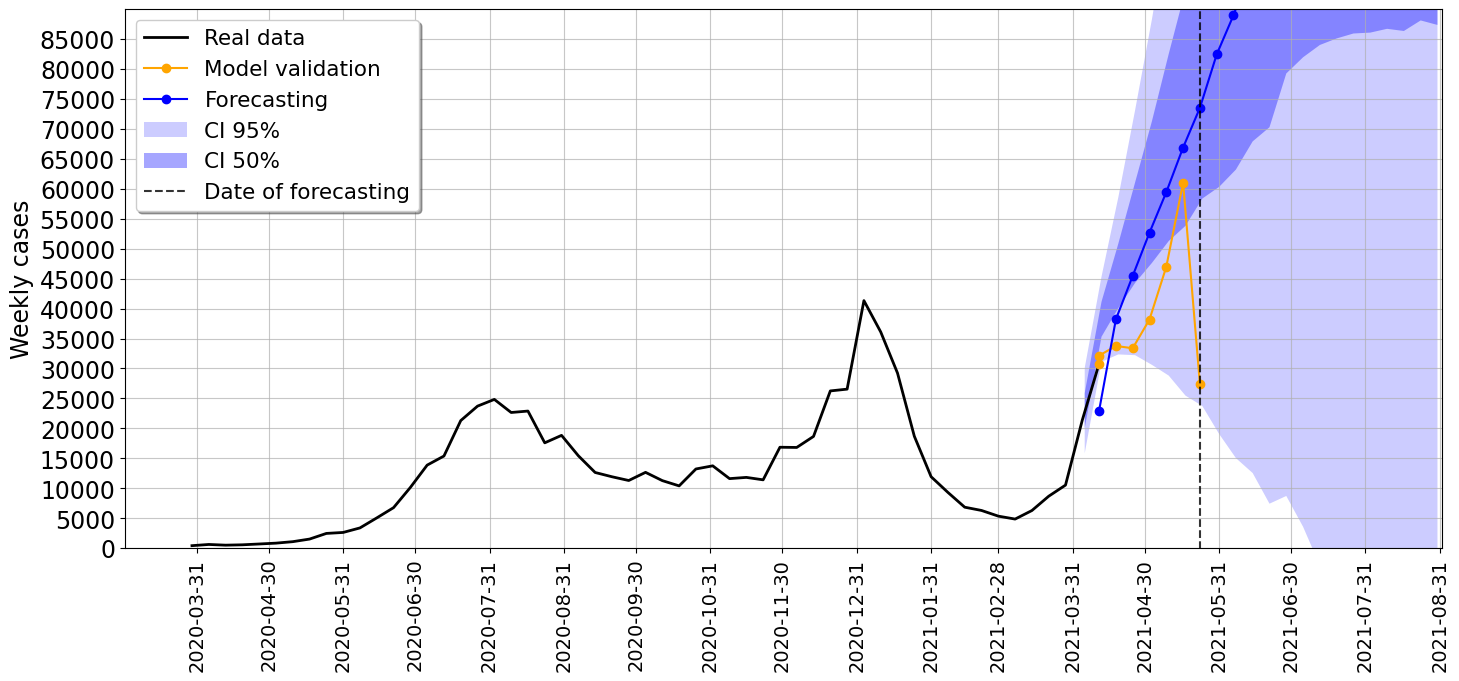

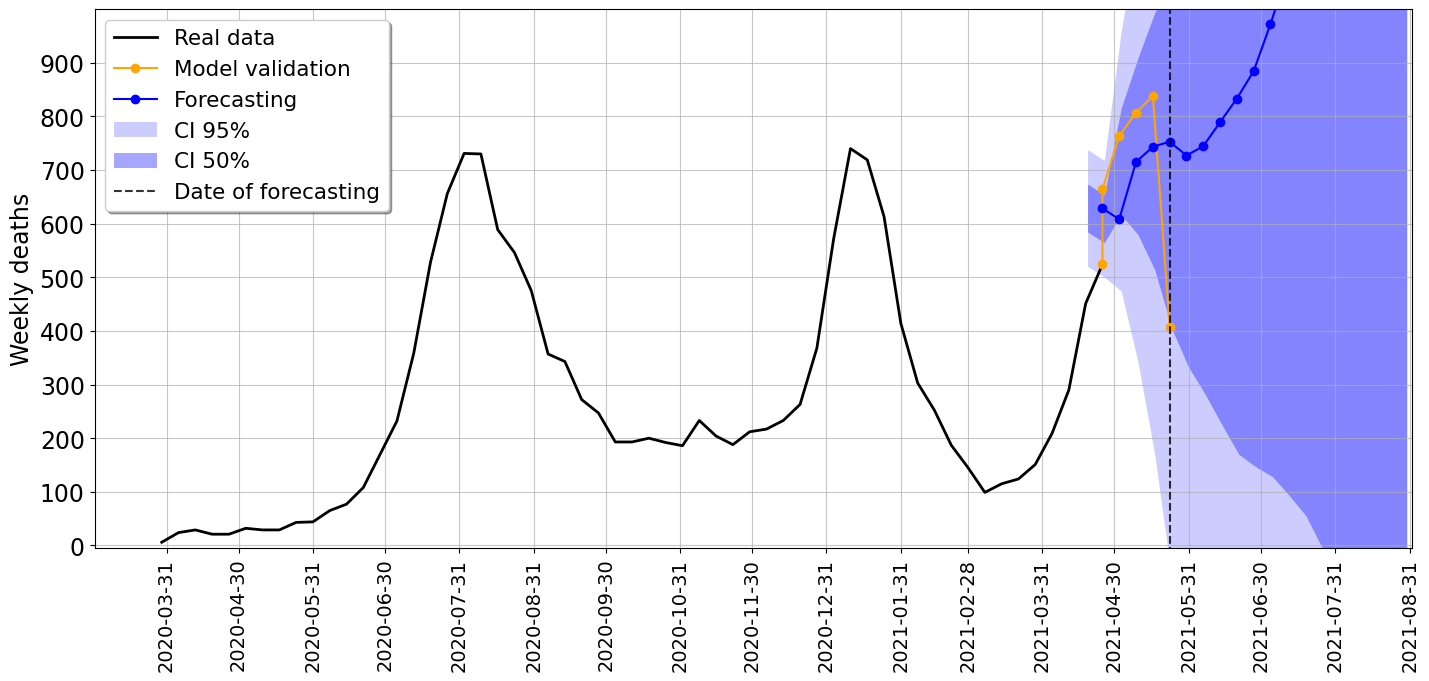

In [9]:
pred_size = 15 # Future forecasting points

vars_ = ["cases", "deaths"]
lower_percentile = 0.05
upper_percentile = 1 - lower_percentile
lower_percentile_2 = 0.25
upper_percentile_2 = 1 - lower_percentile_2
dict_periods = {"cases" : 13, "deaths" : 17}
dict_test_size = {"cases" : 7, "deaths" : 5}
dict_indicator = {"cases" : "Weekly cases", "deaths" : "Weekly deaths"}

for n_values, values_ in enumerate(vars_):
    print(f'****************** {values_} ******************')
    
    y_ = df_epi_mc[values_].copy()
    test_size = dict_test_size[values_]
    period_col =  dict_periods[values_]
    all_days = len(y_)
    test_days = test_size
    train_days = all_days - test_days

    dates_train = pd.date_range(y_.index[0], periods = train_days, freq = "W")
    dates_test = pd.date_range(dates_train[-1], periods = test_days, freq = "W")
    dates_pred = pd.date_range(dates_train[-1], periods = test_days + pred_size, freq = "W")
    
    y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = "W"))
    y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
    
    proy_time_window = pd.PeriodIndex(pd.date_range(dates_train[-1], periods = test_size + pred_size, freq = "W"))
    fh = ForecastingHorizon(proy_time_window, is_relative = False)

    forecaster = UnobservedComponents(
        level = "local linear trend",
        freq_seasonal = [{"period": period_col}],
        use_exact_diffuse = True
    )
    forecaster.fit(y_train)
    
    # Projection
    y_pred = forecaster.predict(fh)
    
    # Percentiles
    quantile_pred = forecaster.predict_quantiles(fh, alpha = [lower_percentile, 0.5, upper_percentile])
    quantile_dates = quantile_pred.index.to_timestamp()
    quantile_0025 = quantile_pred[values_][lower_percentile].to_numpy()
    quantile_0975 = quantile_pred[values_][upper_percentile].to_numpy()
    
    quantile_pred_2 = forecaster.predict_quantiles(fh, alpha = [lower_percentile_2, 0.5, upper_percentile_2])
    quantile_dates_2 = quantile_pred_2.index.to_timestamp()
    quantile_025 = quantile_pred_2[values_][lower_percentile_2].to_numpy()
    quantile_075 = quantile_pred_2[values_][upper_percentile_2].to_numpy()
    
    plt.rcParams.update({"font.size": 17})
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(w = 17, h = 7)

    P = []

    # Real data
    p1 = ax1.plot(dates_train, y_train, color = "black", marker = "", linestyle = "-", linewidth = 2, label = "Real data")
    P.append((p1[0],))

    # Validation data
    dates_prueba = np.append(np.array([dates_train[-1]]), np.array([date for date in dates_test]))
    data_prueba = np.append(np.array([y_train[-1]]), np.array([y_val for y_val in y_test]))
    p2 = ax1.plot(dates_prueba, data_prueba, color = "orange", marker = "o", linestyle = "-", label = "Model validation")
    P.append((p2[0],))

    # Forecasting data
    color_ = "blue"
    p3 = ax1.plot(dates_pred, y_pred, color = color_, marker = "o", linestyle = "-", label = "Forecasting")
    ax1.fill_between(
        quantile_dates,
        quantile_0025,
        quantile_0975,
        where = quantile_0975 >= quantile_0025,
        alpha = 0.20,
        facecolor = color_,
        interpolate = True,
        label = "CI 95%"
    )
    ax1.fill_between(
        quantile_dates_2,
        quantile_025,
        quantile_075,
        where = quantile_075 >= quantile_025,
        alpha = 0.35,
        facecolor = color_,
        interpolate = True,
        label = "CI 50%"
    )
    P.append((p3[0],))

    # Plot details
    time_labels = pd.date_range(dt.datetime(2020,1,1), periods = 40, freq = "1M")
    plt.xticks(time_labels, rotation = 90, fontsize = 14)
    ax1.set_xlim(dt.datetime(2020,3,1), dt.datetime(2021,9,1))
    ax1.set_ylabel(dict_indicator[values_])
    
    if values_ == "cases":
        ax1.yaxis.set_ticks(np.arange(0, 90000, 5000))
        ax1.set_ylim(-5, 90000)
    elif values_ == "deaths":
        ax1.yaxis.set_ticks(np.arange(0, 1000, 100))
        ax1.set_ylim(-5, 1000)

    ax1.grid(alpha = 0.7)
    ax1.vlines(x = dates_prueba[-1], ymin = -100, ymax = 200000, colors = "black", alpha = 0.8, linestyle = "dashed", label = "Date of forecasting")
    
    # Legend
    ax1.legend(
        loc = "upper left",
        #bbox_to_anchor = (0.5, 1.11),
        fancybox = True,
        shadow = True,
        ncol = 1,
        fontsize = 15.5
    )
    
    plt.savefig("./figure_proof_{}.png".format(values_), bbox_inches = "tight", pad_inches = 0.03, dpi = 250)